In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize

Using TensorFlow backend.


In [2]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = r'C:\Users\hp\Desktop\ccp'

In [3]:
X_imageid = os.listdir(os.path.join(TRAIN_PATH,'images'))
y_imageid = os.listdir(os.path.join(TRAIN_PATH,'labels','pixel_level_labels_colored'))
X_imageid.sort()
y_imageid.sort()

In [4]:
X = np.zeros((len(X_imageid),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype = np.uint8)
y = np.zeros((len(X_imageid),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype = np.uint8)
print(X.shape,y.shape)

(2098, 128, 128, 3) (2098, 128, 128, 3)


In [5]:
samplesize = 1003
X_imageid = X_imageid[:samplesize]
y_imageid = y_imageid[:samplesize]
X = X[:samplesize]
y = y[:samplesize]

In [6]:
for i,id_ in tqdm(enumerate(X_imageid),total = len(X_imageid)):
    path = os.path.join(TRAIN_PATH,'images',id_)
    img = imread(path)
    img = resize(img,(IMG_HEIGHT,IMG_WIDTH),mode='constant',preserve_range = True)
    X[i] =img
        
    mask_path = os.path.join(TRAIN_PATH,'labels','pixel_level_labels_colored',id_.split('.')[0]+'.png')

    img = imread(mask_path)
  
    img = resize(img,(IMG_HEIGHT,IMG_WIDTH),mode='constant',preserve_range = True)
    y[i] = img

100%|██████████████████████████████████████████████████████████████████████████████| 1003/1003 [01:19<00:00, 12.62it/s]


In [8]:
X = X/255.0
y = y/255.0

In [9]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,random_state = 1000,test_size = 0.2)
print(X_train.shape,X_valid.shape)

(802, 128, 128, 3) (201, 128, 128, 3)


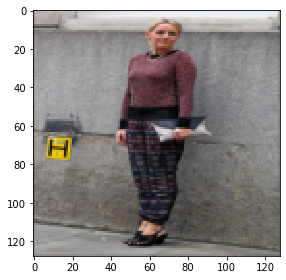

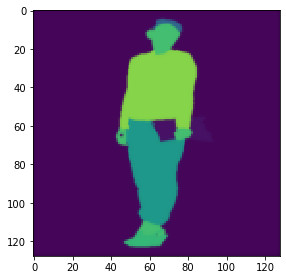

In [10]:
# Random Sample View of image and image mask
image_x = random.randint(0, len(X_train)-1)
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(y_train[image_x]))
plt.show()

In [11]:
# Building U-Net Architecture Model
def build_model():
    tf.keras.backend.clear_session()
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
model = build_model()

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [14]:
results = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=10)

Epoch 1/10
46/46 [==============================] - 57s 1s/step - loss: 0.5561 - accuracy: 0.8211 - val_loss: 0.5396 - val_accuracy: 0.8762
Epoch 2/10
46/46 [==============================] - 57s 1s/step - loss: 0.5296 - accuracy: 0.8641 - val_loss: 0.5109 - val_accuracy: 0.8787
Epoch 3/10
46/46 [==============================] - 58s 1s/step - loss: 0.5102 - accuracy: 0.8702 - val_loss: 0.5059 - val_accuracy: 0.8853
Epoch 4/10
46/46 [==============================] - 55s 1s/step - loss: 0.5057 - accuracy: 0.8802 - val_loss: 0.5070 - val_accuracy: 0.8847
Epoch 5/10
46/46 [==============================] - 56s 1s/step - loss: 0.5047 - accuracy: 0.8816 - val_loss: 0.5021 - val_accuracy: 0.8902
Epoch 6/10
46/46 [==============================] - 56s 1s/step - loss: 0.5026 - accuracy: 0.8872 - val_loss: 0.5010 - val_accuracy: 0.8903
Epoch 7/10
46/46 [==============================] - 56s 1s/step - loss: 0.5017 - accuracy: 0.8898 - val_loss: 0.5007 - val_accuracy: 0.8945
Epoch 8/10
46/46 [==

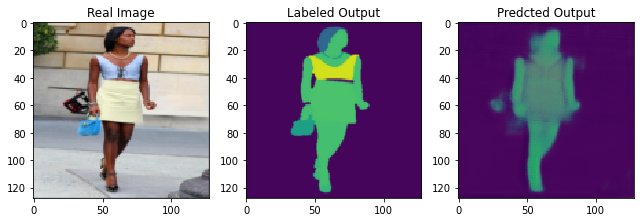

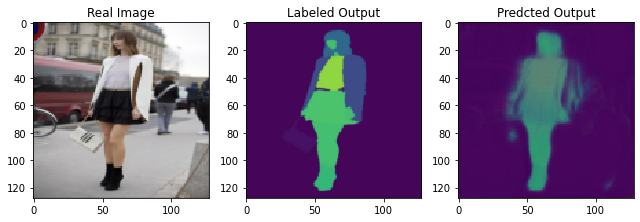

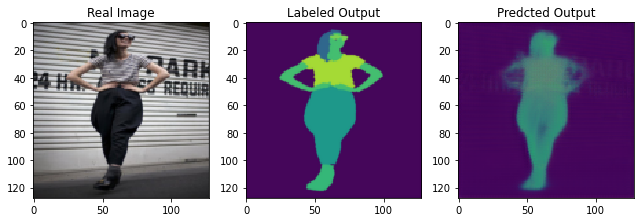

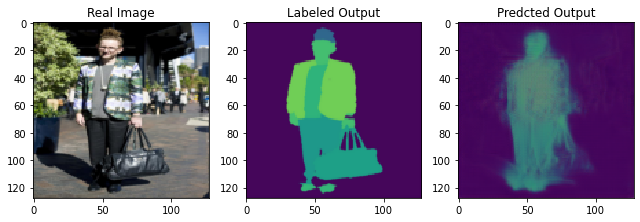

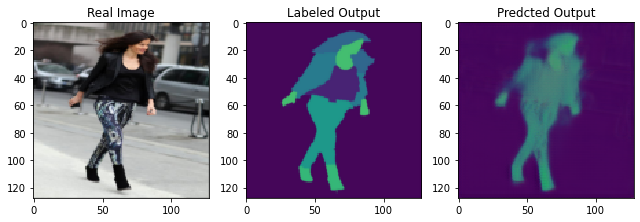

In [16]:
images_x = set()
while(len(images_x)!=5):
    images_x.add(random.randint(0, len(X_valid)-1))

for num,image_x in enumerate(images_x):
    plt.figure(figsize=(9,9))
    plt.subplot(1,3,1)
    plt.title("Real Image")
    imshow(X_valid[image_x])
    
    plt.subplot(1,3,2)
    plt.title("Labeled Output")
    imshow(np.squeeze(y_valid[image_x]))
    
    X_testing = np.expand_dims(X_valid[image_x],axis = 0)
    prediction = model.predict(X_testing)
    plt.subplot(1,3,3)
    plt.title('Predcted Output')
    imshow(np.squeeze(prediction))
    plt.show()